In [1]:
%matplotlib inline


import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, \
    GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, \
    KBinsDiscretizer, OrdinalEncoder


warnings.filterwarnings("ignore")

# <font color=blue>Домашнее задание 5</font>

### Упражнение 1. Kernel trick

Используйте kernel trick, который позволит логистической регрессии достигнуть точности не менее $85\%$. Максимальная точность, которой можно добиться, $\approx 90\%$.

In [13]:
train_url = 'https://raw.githubusercontent.com/PeganovAnton/ml-datasets/master/spiral/train.csv'
test_url = 'https://raw.githubusercontent.com/PeganovAnton/ml-datasets/master/spiral/test.csv'
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

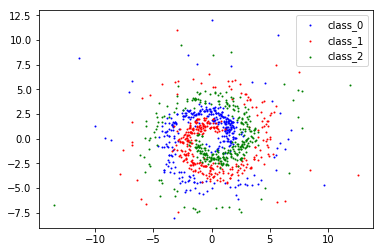

In [14]:
#посмотрим на визуальное представление данных, тобы понять каким образом разделять
class_0 = train_df[train_df['class']==0]
class_1 = train_df[train_df['class']==1]
class_2 = train_df[train_df['class']==2]
plt.scatter(class_0['x'], class_0['y'], color='blue', s=1,label = 'class_0')
plt.scatter(class_1['x'], class_1['y'], color='red', s=1,label = 'class_1')
plt.scatter(class_2['x'], class_2['y'], color='green', s=1,label = 'class_2')
plt.legend(loc='best');

In [162]:
from sklearn.kernel_approximation import RBFSampler
#объединим данные для очистки и преобразования
new_data = pd.concat([train_df, test_df])
X = new_data.drop(['Unnamed: 0','class'], axis=1)
y = new_data['class']
#преобразовывать будем с посощью RBFSampler
rbf_feature = RBFSampler(random_state=1)
transform = rbf_feature.fit_transform(X)
clf = Pipeline(steps=[('preprocessor', rbf_feature),
                    ('classifier', LogisticRegression(multi_class='auto'))])
param_grid = {'classifier__solver': ['newton-cg',
                                     'liblinear','sag','saga','lbfgs'],
             'classifier__C':np.linspace(1,10,50),
             'preprocessor__gamma':np.linspace(2,5,50)
             }
X_train, X_test, y_train, y_test = train_test_split(transform, y, test_size=0.2)
grid_search = GridSearchCV(clf, param_grid, cv=5)#,verbose=5)

grid_search.fit(X_train, y_train)
print(("best score from grid search: %.3f"
                   % grid_search.score(X_test, y_test)))
print(grid_search.best_params_)

Добился результатов :best score from grid search: 0.854
{'classifier__C': 6.327, 'classifier__solver': 'sag', 'preprocessor__gamma': 2.0}

### Упражнение 2. Наивный байесовский классификатор

В библиотеке Sklearn есть 

- класс [`GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) для признаков, распределенных по Гауссу;

- класс [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) для призкаков, подчиняющихся мультиномиальному распределению;

- класс [`BernoulliNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB), который рассматривает каждый признак, как распределенный по Бернулли;

- класс [`CategoricalNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB) для классических категориальных признаков (значение признака не счетчик, как в классификации спама, а какой-то элемент неупорядоченного множества, например {Екатеринбург, Москва, Санкт-Петербург}).

Примените к датасету [Heart](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29) наивный байесовский классификатор. Для этого выберите подходящую модель  из перечисленных выше. В датасете есть категориальные и числовые признаки. Есть 2 способа комбинировать числовые признаки с категориальными:

- дискретизация числовых признаков,

- объединенеие гауссовского классификатора для числовых признаков с дискретной моделью для категориальных признаков.

Второй подход работает так:

- обучаются 2 классификатора &mdash; один на категориальных признаках, а другой &mdash; на числовых,

- параметры обоих классификаторов (условные вероятности признаков) используются для предсказания.

Второй подход можно применять для объединения любых байесовских классификаторов. Например, если часть признаков подчиняется мультиномиаольному распределению, а часть распределению Бернулли.

Сравните эффективность методов в задаче классификации на датасете Heart.

>Используя методы и атрибуты классов `sklearn`, можно объединить модели по крайней мере 2мя способоами. Любое решение в предположении, что признаки условно независимы, засчитывается.

>При решении задачи могут пригодиться классы [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html), [`KBinsDiscretizer`](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html#sphx-glr-auto-examples-preprocessing-plot-discretization-py). Рекомендуется использовать [пайплайны](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline), включающие саму модель, дискретизацию, нормализацию или другие подготовительные действия. Чтобы индивидуально работать с признаками разных типов в рамках пайплайна, подойдет [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html). К моделям на основе классов `Pipeline` и `ColumnTransformer` можно [применять](https://scikit-learn.org/stable/modules/compose.html#pipeline-nested-parameters) `GridSearch`.

>Код для скачивания датасета внизу.

In [10]:
train_url = 'https://raw.githubusercontent.com/PeganovAnton/ml-datasets/master/heart_disease/train.csv'
train_df = pd.read_csv(train_url)

In [11]:
test_url = 'https://raw.githubusercontent.com/PeganovAnton/ml-datasets/master/heart_disease/test.csv'
test_df = pd.read_csv(test_url)

In [12]:
categorical_indices = [1, 2, 5, 6, 8, 10, 11, 12]
numerical_indices = [0, 3, 4, 7, 9]

In [13]:
numerical = []
for i in numerical_indices:
    numerical.append(train_df.columns[i])

categorical = []
for i in categorical_indices:
    categorical.append(train_df.columns[i])

In [14]:
#подготовим данные для подбора оптимальной модели описывающей распределение числовых признаков
train_X = train_df.drop(['class'], axis=1)
train_y = train_df['class']
test_X = test_df.drop(['class'], axis=1)
test_y = test_df['class']

In [16]:
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
    RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, \
    GaussianNB, BernoulliNB
import re

#создадим список лучших параметров
dict_of_best_params = {'Набор количественных признаков:':0,'Нормализатор':0,
                              'Модель:':0,'test_data_score:':int(0)}
scalers =  ["MinMaxScaler" ,"StandardScaler", "RobustScaler", 
            "QuantileTransformer", "PowerTransformer"]

#создадим список комбинаций числовых признаков для выбора модели
#комбинации включают в себя все возможные начиная от одного признака 
res = []
for sub in range(7):
    res.extend(combinations(numerical, sub + 1))
for i in res:
    i = re.sub('[\\()[\\]\'"]', str(i))
    men = []
#долго мучался с лишними кавычками-лучше этого решения не придумал
    number_step = 0
    for el in lst:
        
        el = el.rstrip('\'').lstrip('\'').rstrip('\"').lstrip('\"').lstrip(' ')
        men.append(el)

        for scaler in scalers:
            if scaler=="MinMaxScaler":
                num_transformer = MinMaxScaler()
            elif scaler=="StandardScaler":
                num_transformer = StandardScaler()
            elif scaler=="RobustScaler":
                num_transformer = RobustScaler()
            elif scaler=="QuantileTransformer":
                num_transformer = QuantileTransformer(output_distribution='normal')
            else:
                num_transformer = PowerTransformer('yeo-johnson')

#примемяем ColumnTransformer               
            preprocessor_for_num = ColumnTransformer([('num',num_transformer, men)])
#создаем список моделей для последующего обхода этого списка в цикле    
            classifier = ['GaussianNB()','MultinomialNB()','BernoulliNB()']
#для каждого по очередно               
            for clf in classifier:
#применяется Pipeline первый шаг в котором предобработка(нормализация), второй-само обучение
                if clf=='GaussianNB()':
                    num_classification = \
                    Pipeline(steps=[('num_preprocessor', preprocessor_for_num),
                               ('GaussianNB()', GaussianNB())])
                elif clf=='MultinomialNB()':
                    num_classification = \
                    Pipeline(steps=[('num_preprocessor', preprocessor_for_num),
                               ('MultinomialNB()', MultinomialNB())])
                elif clf=='BernoulliNB()':
                    num_classification = \
                    Pipeline(steps=[('num_preprocessor', preprocessor_for_num),
                               ('BernoulliNB()', BernoulliNB())])
#в процессе обучения выяснилос, что при применении MultinomialNB() если есть отрицательные значения
#вылетает ошибка ValueError Negative values in data passed to MultinomialNB (input X)
#обходим ее через обработку исключений
                try:
                    num_classification.fit(train_X, train_y)
                    score = num_classification.score(test_X, test_y)
                except ValueError:
                    continue
#далее обновляем значения в словаре-по условию что каждый последующий score(test_X, test_y)
#сравнивается с предыдущим по принципу-если больше, то максимален
                if dict_of_best_params["test_data_score:"]<=score:
                    dict_of_best_params["test_data_score:"]=score
                    dict_of_best_params['Модель:']=clf
                    dict_of_best_params['Нормализатор']=num_transformer   
                    dict_of_best_params['Набор количественных признаков:']=men
            number_step+=1
#выводим на печать лучшие параметры    
print(dict_of_best_params)

{'Набор количественных признаков:': ['age', 'cholestoral', 'heart rate', 'oldpeak'], 'Нормализатор': StandardScaler(copy=True, with_mean=True, with_std=True), 'Модель:': 'BernoulliNB()', 'test_data_score:': 0.7777777777777778}


In [18]:
#теперь подготовим данные для объединения моделей
new_data = pd.concat([train_df, test_df])
X = new_data.drop(['class'], axis=1)
y = new_data['class']

In [23]:
from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection

#для категориальных будем использовать OrdinalEncoder()
categorial_transformer = OrdinalEncoder()
preprocessor_for_cat = ColumnTransformer(
    [('cat', categorial_transformer,categorical)])
cat_transform = preprocessor_for_cat.fit_transform(X)
#заменим в датасете на категориальные признаки после трансформации
for i in range(0,8):
    X[categorical[i]] = cat_transform[:,i]
#из предыдущей ячейки возмем лучшие полученнные значения для числовых признаков 
num_transformer = StandardScaler()
numerical = ['age', 'cholestoral', 'heart rate', 'oldpeak']
preprocessor_for_cat = ColumnTransformer(
    [('num', num_transformer,numerical)])
num_transform = preprocessor_for_cat.fit_transform(X)
#заменим в датасете на числовые признаки после трансформации
for i in range(0,4):
    X[numerical[i]] = num_transform[:,i]
clf_cat = CategoricalNB()
clf_num = BernoulliNB()
#первый pipeline для категориальных, второй для числовых
pipe1 = make_pipeline(ColumnSelector(cols=categorical),
                      CategoricalNB())
pipe2 = make_pipeline(ColumnSelector(cols=numerical),
                      BernoulliNB())
# объединяем pipeline 
sclf = StackingCVClassifier(classifiers=[pipe1, pipe2], 
                            meta_classifier=GaussianNB(),
                            use_probas=True,random_state=42)

scores = model_selection.cross_val_score(sclf, X, y, 
                                              cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), 'StackingCVClassifier'))

Accuracy: 0.84 (+/- 0.04) [StackingCVClassifier]


### Упражнение 3

1. Попробуйте разные способы работы с недостающими признаками: удаление, присвоение наиболее правдоподобного значения, введение новой категории `'<UNK>'` для недостающих признаков.

- Попробуйте разные методы подготовки признаков.

- Примените SVM к датасету [Adult](https://archive.ics.uci.edu/ml/datasets/Adult), попробуйте все доступные ядра, подберите для них параметры.

- Подберите лучшую модель для датасета Adult.

In [2]:
train_url = 'https://raw.githubusercontent.com/PeganovAnton/ml-datasets/master/adult/train.csv'
train_df = pd.read_csv(train_url)

In [3]:
test_url = 'https://raw.githubusercontent.com/PeganovAnton/ml-datasets/master/adult/test.csv'
test_df = pd.read_csv(test_url)

In [4]:
#заменим целевой признак на булевые значения
#больше 50К-1,меньше либо равно- 0
train_df['class'] = (train_df['class'] == '>50K').astype(int)
test_df['class'] = (test_df['class'] == '>50K').astype(int)
#объединяем датасет для удобства кодирования
new_data = pd.concat([train_df, test_df])
new_data = new_data.drop([19609])
X = new_data.drop(['class'], axis=1)
y = new_data['class']

In [5]:
#вычисления приходят долго, поэтому решил немного сэкономить на памяти
#переведем тип object в category
#копируем фрейм
copy_data = new_data.copy()
#создаем пустой датафрейм
converted_data = pd.DataFrame()
#пишем цикл, который перебирает каждый столбец object,
#проверяет его на соответствие заданному порогу
#(количество уникальных значений должно быть меньше 50%
#от общего количества значений) и, если столбец 
#удовлетворяет порогу, преобразовывает его в тип category
for col in copy_data.columns:
    num_unique_values = len(copy_data[col].unique())
    num_total_values = len(copy_data[col])
    if num_unique_values / num_total_values < 0.5:
        converted_data.loc[:,col] = copy_data[col].astype('category')
    else:
        converted_data.loc[:,col] = copy_data[col]
#делим признаки на категориальные и числовые
categorical_indices = [1, 3, 5, 6, 7, 8, 9, 13]
numerical_indices = [0, 2, 4, 10, 11, 12]
numerical = []
for i in numerical_indices:
    numerical.append(train_df.columns[i])

categorical = []
for i in categorical_indices:
    categorical.append(train_df.columns[i])
not_full_feats = []
n_a_indices = [1, 6, 13]
for i in n_a_indices:
    not_full_feats.append(train_df.columns[i])

In [ ]:
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV
import category_encoders
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
    RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder

#создаем список нормализаторов, список кодировщиков
scalers =  ["MinMaxScaler" ,"StandardScaler", "RobustScaler", \
            "QuantileTransformer", "PowerTransformer"]
encoders = ['OneHotEncoder()' ,'category_encoders.woe.WOEEncoder()']
#список видов предобработки 
#drop_na_feats-удаление признаков с пропусками
#replace_na_unk-замена ? на '<UNK>'
steps_data_preprocessing = ['drop_na_feats', 'replace_na_unk']

#словарь для хранения лучших параметров 
dict_of_best_params = {'Preproccess_data:':0,'Category_encoder:':0,
                       'Scaler:':0,'Kernel:':0,
                        'test_data_score:':int(0)}
#по очереди перебираем виды предобработки
for step in steps_data_preprocessing:
    if step=='drop_na_feats':
        mod_X = converted_data.drop(['class'], axis=1)
        mod_X = mod_X.drop(not_full_feats, axis=1)
        categorical = [ 'education', 'marital_status', 
                       'relationship', 'race', 'sex']
    else:
        for feat in not_full_feats:
            mod_X = converted_data.drop(['class'], axis=1)
            mod_X[feat] = np.where(mod_X[feat] == '?', '<UNK>', mod_X[feat])
            categorical = ['workclass','education','marital_status',
                           'occupation','relationship','race','sex','native-country']
#далее по очереди перебираем нормализаторы и категориальные энкодеры
    for encoder in encoders:
        if encoder=='OneHotEncoder()' :
            pipe1 =  OneHotEncoder()
        else:
            pipe1 =  category_encoders.woe.WOEEncoder()
        for scaler in scalers:
            if scaler=="MinMaxScaler":
                pipe2 = MinMaxScaler()
            elif scaler=="StandardScaler":
                pipe2 = StandardScaler()
            elif scaler=="RobustScaler":
                pipe2 = RobustScaler()
            elif scaler=="QuantileTransformer":
                pipe2 = QuantileTransformer(output_distribution='normal')
            else:
                pipe2 = PowerTransformer('yeo-johnson')
#применяем ColumnTransformer 
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', pipe2, numerical),
                    ('cat', pipe1, categorical)])
#пайплайн для предобработки и последующей передачи в RandomizedSearchCV
            clf = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', SVC(gamma='auto'))])
#в параметры передаем только ядра 
            param_grid = {'classifier__kernel': ['linear','poly', 'rbf', 'sigmoid']}
            X_train, X_test, y_train, y_test = train_test_split(mod_X, y, test_size=0.2)
            grid_search = RandomizedSearchCV(clf, param_grid, cv=3)#,verbose=10)
            grid_search.fit(X_train, y_train)
            score = grid_search.score(X_test, y_test)
#далее обновляем значения в словаре-по условию что каждый последующий score(test_X, test_y)
#сравнивается с предыдущим по принципу-если больше, то максимален
            if dict_of_best_params["test_data_score:"]<=score:
                dict_of_best_params["test_data_score:"]=score
                dict_of_best_params['Preproccess_data:']=step
                dict_of_best_params['Category_encoder:']=pipe1     
                dict_of_best_params['Scaler:']=pipe2
                dict_of_best_params['Kernel:']=grid_search.best_params_['classifier__kernel']
            
#выводим лучшие параметры            
print(dict_of_best_params)

Лучшие параметры 0.849 достигаются при Category_encoder-WOE, Scaler-StandartScaler, kernel-rbf 

In [12]:
#теперь попробуем подобрать С и gamma
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV
import category_encoders
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
    RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
mod_X = converted_data.drop(['class'], axis=1)
for feat in not_full_feats:
    mod_X[feat] = np.where(mod_X[feat] == '?', '<UNK>', mod_X[feat])
categorical = ['workclass','education','marital_status',
               'occupation','relationship','race','sex','native-country']
pipe1 =  category_encoders.woe.WOEEncoder()
pipe2 = StandardScaler()
preprocessor = ColumnTransformer(
                transformers=[
                    ('num', pipe2, numerical),
                    ('cat', pipe1, categorical)])
#пайплайн для предобработки и последующей передачи в RandomizedSearchCV
clf = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', SVC())])
param_grid = {'classifier__kernel': ['rbf'],
             'classifier__C':[1,0.1],
             'classifier__gamma':[0.125,0.13,0.135,0.14]
             }
X_train, X_test, y_train, y_test = train_test_split(mod_X, y, test_size=0.2)
grid_search = RandomizedSearchCV(clf, param_grid, cv=3)#,verbose=10)
grid_search.fit(X_train, y_train)
print(("best score from grid search: %.3f"
                   % grid_search.score(X_test, y_test)))
print(grid_search.best_params_)

Наилучшие параметры:
best score from grid search: 0.857  
{'classifier__kernel': 'rbf', 'classifier__gamma': 0.135, 'classifier__C': 1}